In [1]:
import zipfile
import requests
import cv2
import matplotlib.pyplot as plt
import glob
import random
import os

## Install Ultralytics Package

In [2]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.0/716.0 kB 7.8 MB/s eta 0:00:00


## Download the Dataset

In [3]:
os.makedirs('datasets', exist_ok=True)

In [4]:
%cd datasets

/content/datasets


In [5]:
# Unzip the data file
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

unzip('/content/downloaded_folder.zip')

Extracted all


In [9]:
%cd ..

/content


## Visualize Images from the Dataset

In [6]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [7]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

In [8]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    all_images.extend(glob.glob(image_paths+'/*.JPG'))

    all_images.sort()

    num_images = len(all_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

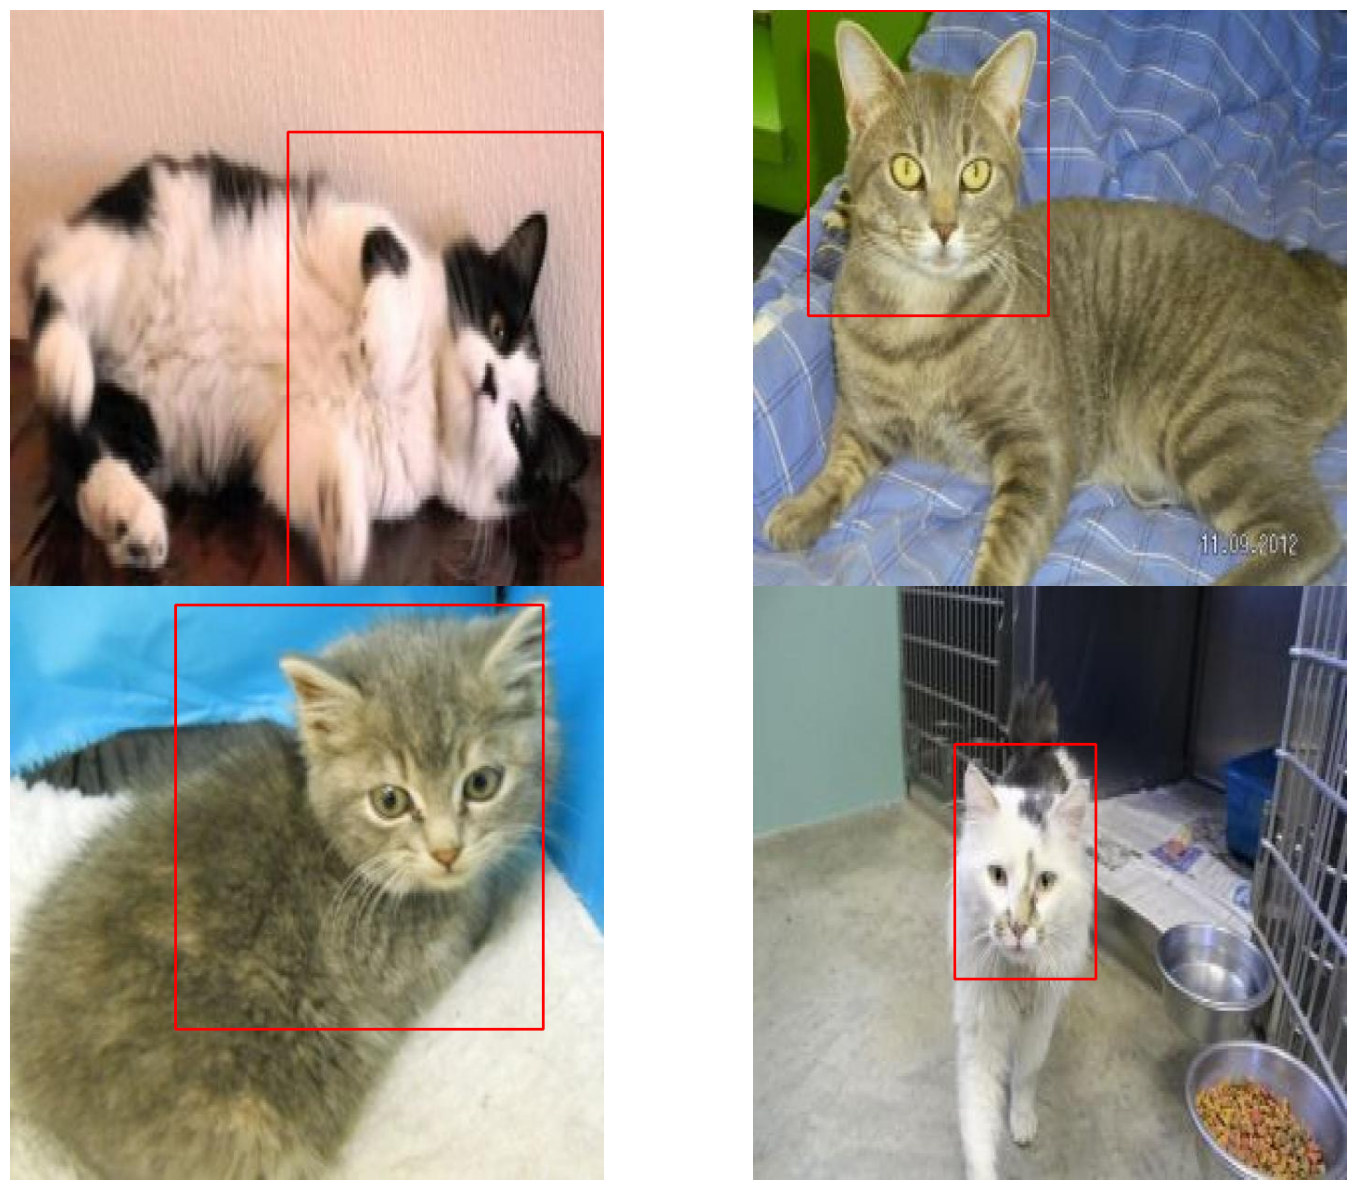

In [9]:
# Visualize a few training images.
plot(
    image_paths='/content/datasets/train/images',
    label_paths='/content/datasets/train/labels',
    num_samples=4,
)

## Dataset YAML File

In [12]:
%%writefile data.yaml
path: '/content/datasets'
train: '/content/datasets/train/images'
val: '/content/datasets/valid/images'

# class names
names:
  0 : cat

Overwriting data.yaml


## YOLOv8 Nano Training

In [ ]:
# Sample training for 5 epoch.
EPOCHS = 50
!yolo task=detect mode=train model=yolov8n.pt imgsz=640 data=data.yaml epochs={EPOCHS} batch=8 name=yolov8n_v8_50e

100% 6.23M/6.23M [00:00<00:00, 108MB/s]
Ultralytics YOLOv8.1.18 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_v8_50e, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_label

In [ ]:
# Plot and visualize images in a 2x2 grid.
def visualize(result_dir, num_samples=4):
    """
    Function accepts a list of images and plots
    them in a 2x2 grid.
    """
    plt.figure(figsize=(20, 12))
    image_names = glob.glob(os.path.join(result_dir, '*.jpg'))
    random.shuffle(image_names)
    for i, image_name in enumerate(image_names):
        image = plt.imread(image_name)
        plt.subplot(2, 2, i+1)
        plt.imshow(image)
        plt.axis('off')
        if i == num_samples-1:
            break
    plt.tight_layout()
    plt.show()

In [ ]:
visualize('/content/runs/detect/yolov8n_v8_50e_infer1280')

## Evaluation on Validation Images

In [18]:
!yolo task=detect mode=val model=/content/runs/detect/yolov8n_v8_50e3/weights/best.pt name=yolov8n_eval data=data.yaml

Ultralytics YOLOv8.1.18 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/datasets/valid/labels.cache... 3 images, 0 backgrounds, 0 corrupt: 100% 3/3 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 1/1 [00:00<00:00,  1.05it/s]
                   all          3          3    0.00333          1       0.61      0.218
Speed: 0.9ms preprocess, 67.8ms inference, 0.0ms loss, 178.1ms postprocess per image
Results saved to runs/detect/yolov8n_eval
💡 Learn more at https://docs.ultralytics.com/modes/val


## Inference on Validation Images

In [19]:
!yolo task=detect \
mode=predict \
model=/content/runs/detect/yolov8n_v8_50e3/weights/best.pt \
source=/content/datasets/valid/images \
imgsz=1280 \
name=yolov8n_v8_50e_infer1280 \
hide_labels=True

WARNING ⚠️ 'hide_labels' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_labels' instead.
Ultralytics YOLOv8.1.18 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs

image 1/3 /content/datasets/valid/images/AmericanBobtail-23264765_3753_jpg.rf.2ca7ee22f854982ae9a7268683a1937a.jpg: 1280x1280 (no detections), 24.1ms
image 2/3 /content/datasets/valid/images/AmericanBobtail-29563308_2669_jpg.rf.671563d1e2f3584b20632b16e8eb7396.jpg: 1280x1280 (no detections), 19.6ms
image 3/3 /content/datasets/valid/images/AmericanBobtail-32714423_2134_jpg.rf.e75722f9ea8fb9853b1cb01eea2db2e7.jpg: 1280x1280 (no detections), 19.5ms
Speed: 24.5ms preprocess, 21.1ms inference, 17.8ms postprocess per image at shape (1, 3, 1280, 1280)
Results saved to runs/detect/yolov8n_v8_50e_infer1280
💡 Learn more at https://docs.ultralytics.com/modes/predict


## Visualize Validation Results

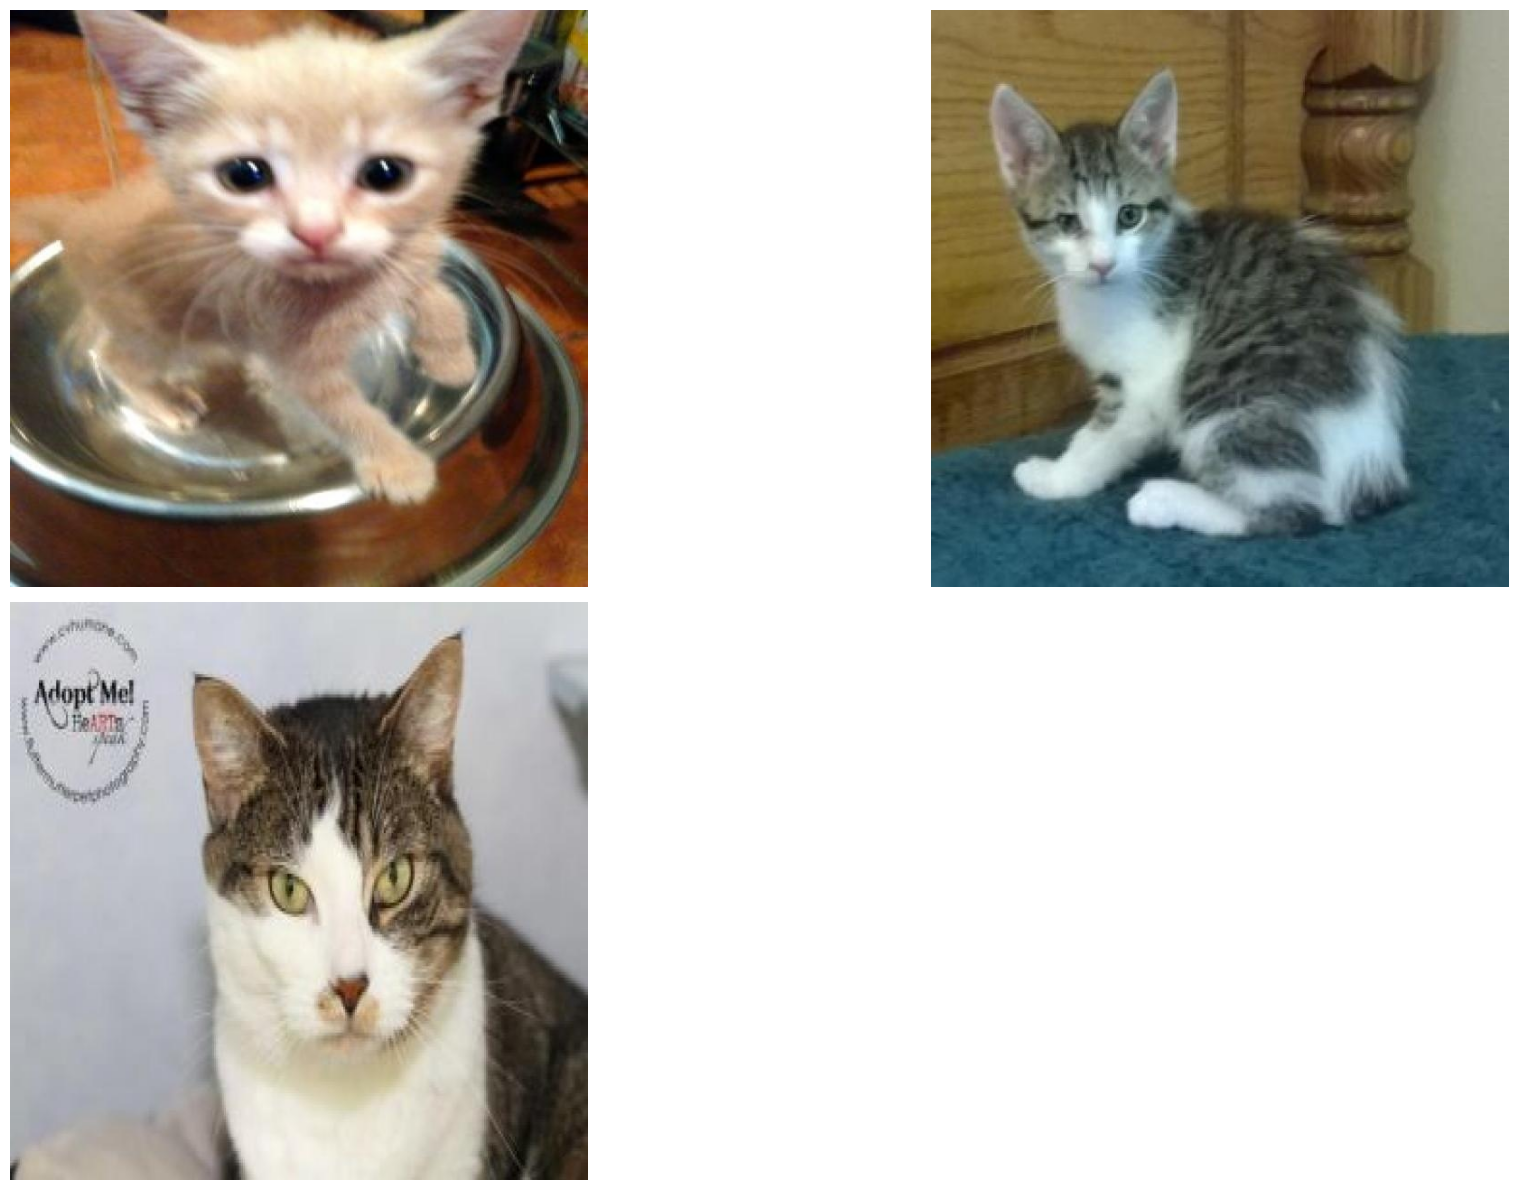

In [21]:
visualize('/content/runs/detect/yolov8n_v8_50e_infer1280')

Predict

In [24]:
!yolo task=detect mode=predict model=/content/runs/detect/yolov8n_v8_50e3/weights/best.pt name=yolov8n_pred data=data.yaml

WARNING ⚠️ 'source' is missing. Using default 'source=/usr/local/lib/python3.10/dist-packages/ultralytics/assets'.
Ultralytics YOLOv8.1.18 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs

image 1/2 /usr/local/lib/python3.10/dist-packages/ultralytics/assets/bus.jpg: 1280x960 (no detections), 81.6ms
image 2/2 /usr/local/lib/python3.10/dist-packages/ultralytics/assets/zidane.jpg: 736x1280 (no detections), 62.3ms
Speed: 12.6ms preprocess, 71.9ms inference, 8.7ms postprocess per image at shape (1, 3, 736, 1280)
Results saved to runs/detect/yolov8n_pred2
💡 Learn more at https://docs.ultralytics.com/modes/predict


In [25]:
!yolo task=detect \
mode=predict \
model=/content/runs/detect/yolov8n_v8_50e3/weights/best.pt \
source=/content/datasets/test/images \
imgsz=1280 \
name=yolov8n_v8_50e_predict \
hide_labels=True

WARNING ⚠️ 'hide_labels' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_labels' instead.
Ultralytics YOLOv8.1.18 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs

image 1/3 /content/datasets/test/images/AmericanBobtail-32714423_2134_jpg.rf.9dc77ae0fb329de309016c254676d18c.jpg: 1280x1280 (no detections), 24.7ms
image 2/3 /content/datasets/test/images/AmericanBobtail-33779126_1927_jpg.rf.a61bd994eb87acc7f24586a64d2a8c79.jpg: 1280x1280 (no detections), 19.5ms
image 3/3 /content/datasets/test/images/AmericanBobtail-34466601_1814_jpg.rf.069253db28e3c4dbeb81aa0bef9748b7.jpg: 1280x1280 (no detections), 19.5ms
Speed: 13.1ms preprocess, 21.2ms inference, 16.5ms postprocess per image at shape (1, 3, 1280, 1280)
Results saved to runs/detect/yolov8n_v8_50e_predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


In [26]:
visualize('/content/runs/detect/yolov8n_v8_50e_predict/AmericanBobtail-32714423_2134_jpg.rf.9dc77ae0fb329de309016c254676d18c.jpg')

<Figure size 2000x1200 with 0 Axes>